<a href="https://colab.research.google.com/github/ArezooAalipanah/machine_learning3/blob/main/hml_ch11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chapter 11: Training Deep Neural Networks 🦔

## Vanishing/Exploding Gradient Problem

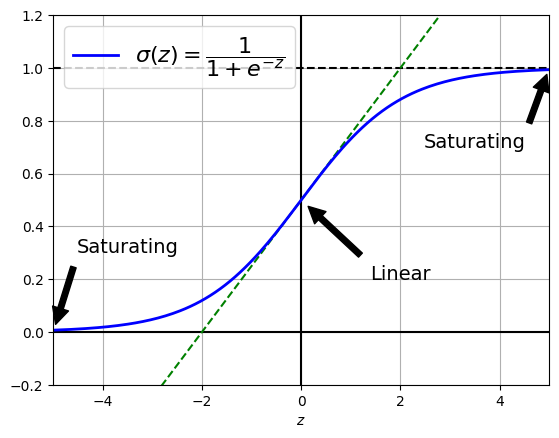

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(z):
  return 1/ (1+ np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)


##Glorot and He Initialization

In [2]:
# setting initializations
import tensorflow as tf

dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

In [3]:
#if you want He initialization with a uniform distribution and based on fanavg

he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")

dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

##Better Activation Functions

### Leaky ReLU

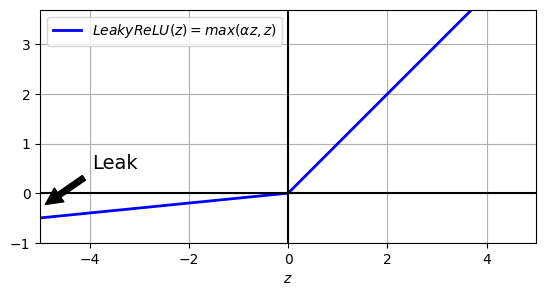

In [4]:
def leaky_relu(z, alpha):
  return np.maximum(alpha*z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)

props = dict(facecolor='black', shrink=0.1)
plt.annotate("Leak", xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops = props,
             fontsize = 14, ha = "center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

In [5]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha = 0.2) #defaults to alpha = 0.3
dense = tf.keras.layers.Dense(50, activation = leaky_relu,
                              kernel_initializer="he_normal")

In [6]:
# use leaky relu as a seperate layer in the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, kernel_initializer = "he_normal"), # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2)# activation as a seperate layer
])

### ELU

In [7]:
#Implementing ELU in TensorFlow
dense = tf.keras.layers.Dense(50, activation = "elu",
                              kernel_initializer="he_normal")

### SELU

By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too, and other constraints are respected, as explained in the book). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

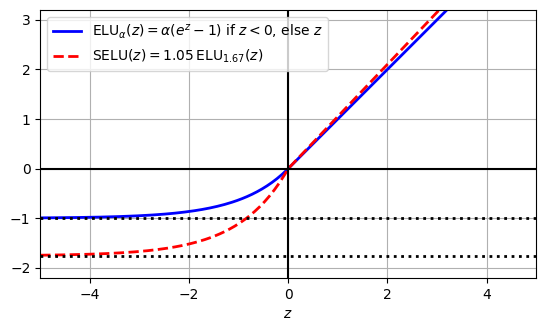

In [8]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

In [9]:
# using SELU straight forward:

dense = tf.keras.layers.Dense(50, activation = "selu",
                              kernel_initializer = "lecun_normal")

In [10]:
#example of a self-regularized network using SELU

#neural net for Fashion MNIST with 100 hidden layers,
#using the SELU activation function:

tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [11]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [12]:
#let's train.Do not forget to scale the inputs to mean 0 and standard deviation 1:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

4422102/4422102 [==============================] - 1s 0us/step


In [13]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [14]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [15]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 96s 46ms/step - loss: 1.1719 - accuracy: 0.5508 - val_loss: 0.7890 - val_accuracy: 0.7226
Epoch 2/5
1719/1719 [==============================] - 62s 36ms/step - loss: 0.6817 - accuracy: 0.7562 - val_loss: 0.5963 - val_accuracy: 0.7858
Epoch 3/5
1719/1719 [==============================] - 38s 22ms/step - loss: 0.5691 - accuracy: 0.8001 - val_loss: 0.5252 - val_accuracy: 0.8148
Epoch 4/5
1719/1719 [==============================] - 38s 22ms/step - loss: 0.5113 - accuracy: 0.8229 - val_loss: 0.5047 - val_accuracy: 0.8266
Epoch 5/5
1719/1719 [==============================] - 43s 25ms/step - loss: 0.4772 - accuracy: 0.8343 - val_loss: 0.4731 - val_accuracy: 0.8372


The network managed to learn, despite how deep it is. Now look at what happens if we try to use the ReLU activation function instead:

In [16]:
tf.random.set_seed(42)

In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [18]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [19]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 67s 30ms/step - loss: 2.1260 - accuracy: 0.1610 - val_loss: 1.9573 - val_accuracy: 0.1860
Epoch 2/5
1719/1719 [==============================] - 56s 33ms/step - loss: 1.7147 - accuracy: 0.3220 - val_loss: 1.4795 - val_accuracy: 0.3820
Epoch 3/5
1719/1719 [==============================] - 48s 28ms/step - loss: 1.3343 - accuracy: 0.4653 - val_loss: 1.2936 - val_accuracy: 0.5226
Epoch 4/5
1719/1719 [==============================] - 60s 35ms/step - loss: 1.1100 - accuracy: 0.5471 - val_loss: 0.9850 - val_accuracy: 0.5912
Epoch 5/5
1719/1719 [==============================] - 55s 32ms/step - loss: 1.3535 - accuracy: 0.4674 - val_loss: 2.0051 - val_accuracy: 0.2828


Not great at all, we suffered from the vanishing/exploding gradients problem.

### GELU, Swish and Mish

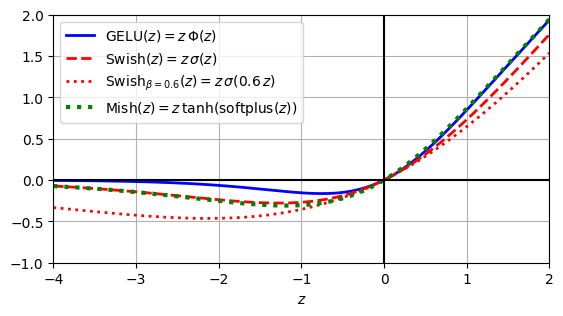

In [20]:
def swish(Z, beta=1):
  return z * sigmoid(beta * z)

def approx_gelu(z):
  return swish(z, beta =1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

## Batch Normalization

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = [28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                   kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")

])


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [24]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [25]:
# just show that the model works! 😊
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "sgd",
              metrics = "accuracy")
model.fit(X_train, y_train, epochs=2, validation_data = (X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 21s 11ms/step - loss: 0.5542 - accuracy: 0.8090 - val_loss: 0.4045 - val_accuracy: 0.8500
Epoch 2/2
1719/1719 [==============================] - 20s 12ms/step - loss: 0.4055 - accuracy: 0.8551 - val_loss: 0.3667 - val_accuracy: 0.8624


Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)


In [27]:
#BN before the activation
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer= "he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias = False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation = "softmax")
])

In [28]:
# show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 16s 9ms/step - loss: 0.6132 - accuracy: 0.7945 - val_loss: 0.4480 - val_accuracy: 0.8380
Epoch 2/2
1719/1719 [==============================] - 18s 10ms/step - loss: 0.4318 - accuracy: 0.8499 - val_loss: 0.3807 - val_accuracy: 0.8612


### Gradient Clipping
All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments:

In [29]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [30]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers

### Reusing a Keras Model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
* `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [31]:
#  split Fashion MNIST into tasks A and B, then train and save
#  model A to "my_model_A".

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 9s 6ms/step - loss: 1.2353 - accuracy: 0.5894 - val_loss: 0.7396 - val_accuracy: 0.7684
Epoch 2/20
1376/1376 [==============================] - 9s 6ms/step - loss: 0.6232 - accuracy: 0.8008 - val_loss: 0.5179 - val_accuracy: 0.8300
Epoch 3/20
1376/1376 [==============================] - 7s 5ms/step - loss: 0.4864 - accuracy: 0.8431 - val_loss: 0.4374 - val_accuracy: 0.8531
Epoch 4/20
1376/1376 [==============================] - 9s 7ms/step - loss: 0.4235 - accuracy: 0.8609 - val_loss: 0.3931 - val_accuracy: 0.8636
Epoch 5/20
1376/1376 [==============================] - 8s 6ms/step - loss: 0.3859 - accuracy: 0.8727 - val_loss: 0.3651 - val_accuracy: 0.8711
Epoch 6/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.3603 - accuracy: 0.8788 - val_loss: 0.3465 - val_accuracy: 0.8759
Epoch 7/20
1376/1376 [==============================] - 6s 4ms/step - loss: 0.3420 - accuracy: 0.8850 - val_loss: 0.3313 - val_accuracy:

In [32]:
#  train and evaluate model B, without reusing model A
tf.random.set_seed(42)

model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = [28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])
model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate = 0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs = 20,
                      validation_data = (X_valid_B, y_valid_B))

model_B.evaluate(X_test_B, y_test_B)


Epoch 1/20
7/7 [==============================] - 1s 43ms/step - loss: 0.7375 - accuracy: 0.5550 - val_loss: 0.7377 - val_accuracy: 0.5153
Epoch 2/20
7/7 [==============================] - 0s 17ms/step - loss: 0.6952 - accuracy: 0.5550 - val_loss: 0.7027 - val_accuracy: 0.5153
Epoch 3/20
7/7 [==============================] - 0s 30ms/step - loss: 0.6652 - accuracy: 0.5550 - val_loss: 0.6777 - val_accuracy: 0.5163
Epoch 4/20
7/7 [==============================] - 0s 15ms/step - loss: 0.6417 - accuracy: 0.5500 - val_loss: 0.6548 - val_accuracy: 0.5203
Epoch 5/20
7/7 [==============================] - 0s 16ms/step - loss: 0.6215 - accuracy: 0.5500 - val_loss: 0.6334 - val_accuracy: 0.5312
Epoch 6/20
7/7 [==============================] - 0s 18ms/step - loss: 0.6022 - accuracy: 0.5700 - val_loss: 0.6142 - val_accuracy: 0.5529
Epoch 7/20
7/7 [==============================] - 0s 17ms/step - loss: 0.5839 - accuracy: 0.5950 - val_loss: 0.5957 - val_accuracy: 0.6192
Epoch 8/20
7/7 [===========

[0.46925806999206543, 0.8949999809265137]

Model B reaches 91.85% accuracy on the test set. Now let's try reusing the pretrained model A.

In [33]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A =tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation = "sigmoid"))


Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`:

In [34]:
tf.random.set_seed(42)

In [35]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [36]:
#creating model_B_on_A just like in the previous cell
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [37]:
# we should make the layers NOT trainable to avoid changing the weights with
# huge gradients esp. on the first epochs
for layer in model_B_on_A.layers[:-1]:
  layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss = "binary_crossentropy", optimizer = optimizer,
                     metrics = ["accuracy"])

In [38]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data = (X_valid_B, y_valid_B))


Epoch 1/4
7/7 [==============================] - 1s 82ms/step - loss: 0.5052 - accuracy: 0.7550 - val_loss: 0.5207 - val_accuracy: 0.8042
Epoch 2/4
7/7 [==============================] - 0s 24ms/step - loss: 0.4712 - accuracy: 0.8400 - val_loss: 0.5124 - val_accuracy: 0.8249
Epoch 3/4
7/7 [==============================] - 0s 22ms/step - loss: 0.4634 - accuracy: 0.8700 - val_loss: 0.5086 - val_accuracy: 0.8150
Epoch 4/4
7/7 [==============================] - 0s 20ms/step - loss: 0.4563 - accuracy: 0.8550 - val_loss: 0.5021 - val_accuracy: 0.8220


In [40]:
# after we train the model for some epochs it's time to make the layers trainable
for layer in model_B_on_A.layers[:-1]:
  layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss = "binary_crossentropy", optimizer = optimizer,
                     metrics = ["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs = 16,
                           validation_data = (X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 2s 43ms/step - loss: 0.4386 - accuracy: 0.8700 - val_loss: 0.4734 - val_accuracy: 0.8684
Epoch 2/16
7/7 [==============================] - 0s 15ms/step - loss: 0.4057 - accuracy: 0.9200 - val_loss: 0.4261 - val_accuracy: 0.9070
Epoch 3/16
7/7 [==============================] - 0s 17ms/step - loss: 0.3651 - accuracy: 0.9450 - val_loss: 0.4026 - val_accuracy: 0.9011
Epoch 4/16
7/7 [==============================] - 0s 17ms/step - loss: 0.3390 - accuracy: 0.9400 - val_loss: 0.3789 - val_accuracy: 0.9149
Epoch 5/16
7/7 [==============================] - 0s 17ms/step - loss: 0.3192 - accuracy: 0.9550 - val_loss: 0.3577 - val_accuracy: 0.9298
Epoch 6/16
7/7 [==============================] - 0s 17ms/step - loss: 0.3002 - accuracy: 0.9600 - val_loss: 0.3421 - val_accuracy: 0.9308
Epoch 7/16
7/7 [==============================] - 0s 17ms/step - loss: 0.2833 - accuracy: 0.9650 - val_loss: 0.3374 - val_accuracy: 0.9308
Epoch 8/16
7/7 [===========

In [41]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 4ms/step - loss: 0.2613 - accuracy: 0.9350


[0.2613283693790436, 0.9350000023841858]

#### How science can fool you :D
Great! We got a bit of transfer: the model's accuracy went up 4 percentage points, from 89.5% to 93.5%. This means the error rate dropped by almost 40%:


In [42]:
1 - (100 - 93.5) / (100 - 89.5)

0.38095238095238093

# Faster Optimizers